# 패키지 임포트

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim

# 데이터 로드

In [15]:
df = pd.read_csv('../data/Churn_Modelling.csv')
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)
df = pd.get_dummies(df, columns = ['Geography', 'Gender'], drop_first=True)
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,0,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,1,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,1,True,False,True


# 데이터 전처리

In [16]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [17]:
# 데이터 전처리
sc = StandardScaler()
X = sc.fit_transform(X)

# y는 1차원 배열이므로 2차원으로 변경
y = y.to_numpy().reshape(-1, 1)

# Tensor 데이터 준비
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [18]:
# 데이터 분할
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2)

# MLP 모델 정의

In [19]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.net(x)

model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train

In [20]:
# 학습 루프
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()  # 최적화함수 초기화
    pred = model(X_train)  # 모델 예측
    loss = criterion(pred, y_train)  # 손실 계산
    loss.backward()  # 역전파(기울기 계산)
    optimizer.step()  # 가중치/절편 업데이트

    # 정확도 계산
    with torch.no_grad():
        model.eval()
        logits = model(X_test) 
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()

        correct = (preds == y_test).sum().item()
        accuracy = correct / y_test.size(0)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.4f}')

Epoch 100: Loss = 0.4393, Accuracy = 0.8055
Epoch 200: Loss = 0.3664, Accuracy = 0.8470
Epoch 300: Loss = 0.3288, Accuracy = 0.8580
Epoch 400: Loss = 0.3175, Accuracy = 0.8580
Epoch 500: Loss = 0.3093, Accuracy = 0.8575
Epoch 600: Loss = 0.3021, Accuracy = 0.8570
Epoch 700: Loss = 0.2952, Accuracy = 0.8585
Epoch 800: Loss = 0.2886, Accuracy = 0.8590
Epoch 900: Loss = 0.2831, Accuracy = 0.8565
Epoch 1000: Loss = 0.2784, Accuracy = 0.8575


# MLP 모델 저장

In [ ]:
# torch.save(model.state_dict(), '../models/MLP.pth')

# 성능지표

In [22]:
model.load_state_dict(torch.load('../models/MLP.pth'))
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [23]:
# 정확도 계산
with torch.no_grad():
    model.eval()
    logits = model(X_test) 
    probs = torch.sigmoid(logits)
    y_preds = (probs >= 0.5).float()

In [24]:
y_preds = y_preds.cpu().numpy()
y_test = y_test.cpu().numpy()

# 정확도
acc = accuracy_score(y_test, y_preds)
print("✅ Accuracy:", acc)

# 정밀도, 재현율, F1 등 전체 리포트
print("\n📋 Classification Report:")
print(classification_report(y_test, y_preds))

✅ Accuracy: 0.8575

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      1604
         1.0       0.70      0.49      0.58       396

    accuracy                           0.86      2000
   macro avg       0.79      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



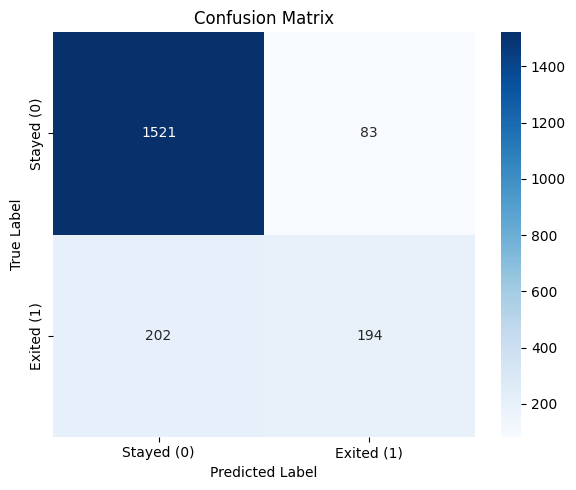

In [25]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_preds)

# 라벨 지정 (0: 잔류, 1: 이탈)
labels = ['Stayed (0)', 'Exited (1)']

# 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()



🔥 AUC Score: 0.8414


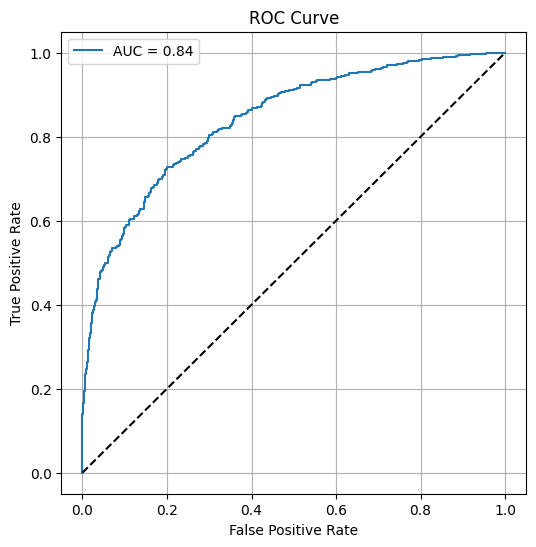

In [26]:
# AUC 계산
auc = roc_auc_score(y_test, probs)
print(f"\n🔥 AUC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()